# Plotting with VegaLite

## Setup

To render graphs in Livebook, we need the
[`vega_lite`](https://github.com/elixir-nx/vega_lite) package
for defining our graph specification

In [1]:
Mix.install([
  {:vega_lite, "~> 0.1.0"}
])

:ok

`IElixir` knows how to render **VegaLite** plots by itself - you don't need to use any side libraries for it! The only thing you need - is to get it's schema representation using `VegaLite.to_spec/1` function.

Alternative way - is to define `IElixir.Display` protocol for `VegaLite` structure, that will call this function automatically for us. We will do it in the beginning of this notebook:

In [2]:
defimpl IElixir.Displayable, for: VegaLite do
  def display(vl), do: VegaLite.to_spec(vl)
end

{:module, IElixir.Displayable.VegaLite,
 <<70, 79, 82, 49, 0, 0, 7, 32, 66, 69, 65, 77, 65, 116, 85, 56, 0, 0, 0, 242, 0, 0, 0, 21, 35, 69,
   108, 105, 120, 105, 114, 46, 73, 69, 108, 105, 120, 105, 114, 46, 68, 105, 115, 112, 108, 97,
   121, ...>>, {:__impl__, 1}}

When building graphics we make extensive use of the functions from `VegaLite`,
so it's useful to alias the module as something shorter.

In [3]:
alias VegaLite, as: Vl

VegaLite

## Basic concepts

Composing a basic Vega-Lite graphic usually consists of the following steps:

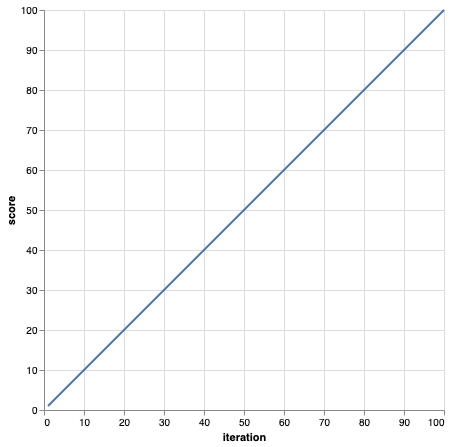

In [4]:
# Initialize the specification, optionally with some top-level properties
Vl.new(width: 400, height: 400)
# Specify data source for the graphic using one of the data_from_* functions
|> Vl.data_from_series(iteration: 1..100, score: 1..100)
# Pick a visual mark
|> Vl.mark(:line)
# Map data fields to visual properties of the mark, in this case point positions
|> Vl.encode_field(:x, "iteration", type: :quantitative)
|> Vl.encode_field(:y, "score", type: :quantitative)
# Here, if we've not defined the protocol, next line must be appended:
# |> Vl.to_spec

Below you can find a number of example graphics for common use cases.
For a number of plain Vega-Lite examples you can look
[here](https://vega.github.io/vega-lite/examples).

## Bar charts

### Simple bar chart

A bar chart encodes quantitative values as the length of regular bars.

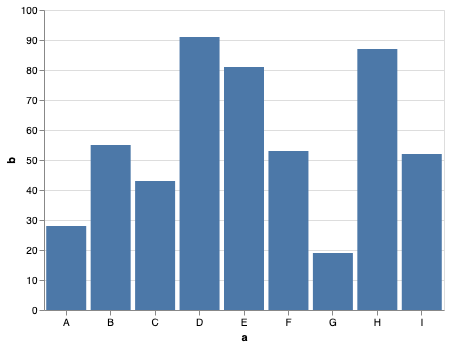

In [5]:
# Source: https://vega.github.io/vega-lite/examples/bar.html

data = [
  %{"a" => "A", "b" => 28},
  %{"a" => "B", "b" => 55},
  %{"a" => "C", "b" => 43},
  %{"a" => "D", "b" => 91},
  %{"a" => "E", "b" => 81},
  %{"a" => "F", "b" => 53},
  %{"a" => "G", "b" => 19},
  %{"a" => "H", "b" => 87},
  %{"a" => "I", "b" => 52}
]

Vl.new(width: 400, height: 300)
|> Vl.data_from_values(data)
|> Vl.mark(:bar)
|> Vl.encode_field(:x, "a", type: :nominal, axis: [label_angle: 0])
|> Vl.encode_field(:y, "b", type: :quantitative)
|> Vl.to_spec

### Stacked bar chart

A stacked bar chart contains multi-color bars to represent
several quantitive values at once.

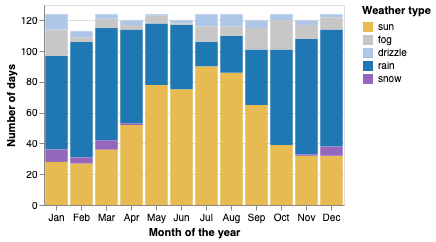

In [6]:
# Source: https://vega.github.io/vega-lite/examples/stacked_bar_weather.html

Vl.new(width: 300, height: 200)
|> Vl.data_from_url("https://vega.github.io/editor/data/seattle-weather.csv")
|> Vl.mark(:bar)
|> Vl.encode_field(:x, "date", time_unit: :month, type: :ordinal, title: "Month of the year")
|> Vl.encode(:y, aggregate: :count, type: :quantitative, title: "Number of days")
|> Vl.encode_field(:color, "weather",
  type: :nominal,
  title: "Weather type",
  scale: [
    domain: ["sun", "fog", "drizzle", "rain", "snow"],
    range: ["#e7ba52", "#c7c7c7", "#aec7e8", "#1f77b4", "#9467bd"]
  ]
)

### Grouped bar chart

Graphing one bar plot per group.

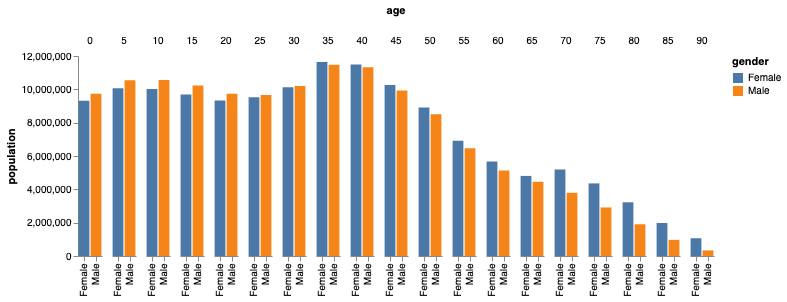

In [7]:
# Source: https://vega.github.io/vega-lite/examples/bar_grouped.html

Vl.new(width: [step: 12])
|> Vl.data_from_url("https://vega.github.io/editor/data/population.json")
|> Vl.transform(filter: "datum.year == 2000")
|> Vl.transform(calculate: "datum.sex == 2 ? 'Female' : 'Male'", as: "gender")
|> Vl.mark(:bar)
|> Vl.encode_field(:column, "age", type: :ordinal, spacing: 10)
|> Vl.encode_field(:y, "people", aggregate: :sum, title: "population", axis: [grid: false])
|> Vl.encode_field(:x, "gender", title: nil)
|> Vl.encode_field(:color, "gender")
|> Vl.config(view: [stroke: nil])

## Histograms, density plots and dot plots

### Histogram

A histogram represents the value frequency in predefined intervals.

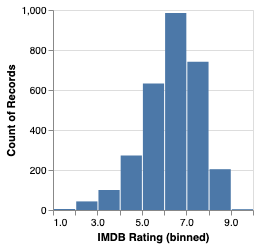

In [8]:
# Source: https://vega.github.io/vega-lite/examples/histogram.html

Vl.new()
|> Vl.data_from_url("https://vega.github.io/editor/data/movies.json")
|> Vl.mark(:bar)
|> Vl.encode_field(:x, "IMDB Rating", bin: true)
|> Vl.encode(:y, aggregate: :count)

### Density plot

A density plot represents the distribution estimate of a numeric value.

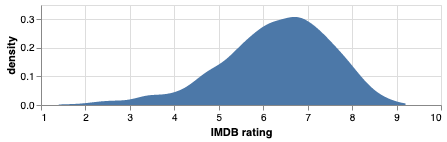

In [9]:
# Source: https://vega.github.io/vega-lite/examples/area_density.html

Vl.new(width: 400, height: 100)
|> Vl.data_from_url("https://vega.github.io/editor/data/movies.json")
|> Vl.transform(density: "IMDB Rating")
|> Vl.mark(:area)
|> Vl.encode_field(:x, "value", type: :quantitative, title: "IMDB rating")
|> Vl.encode_field(:y, "density", type: :quantitative)

### Stacked density estimates

Several density plots stacked together.

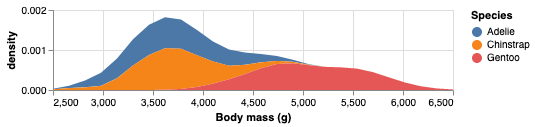

In [10]:
# Source: https://vega.github.io/vega-lite/examples/area_density_stacked.html

Vl.new(width: 400, height: 80)
|> Vl.data_from_url("https://vega.github.io/editor/data/penguins.json")
|> Vl.transform(density: "Body Mass (g)", groupby: ["Species"], extent: [2500, 6500])
|> Vl.mark(:area)
|> Vl.encode_field(:x, "value", type: :quantitative, title: "Body mass (g)")
|> Vl.encode_field(:y, "density", type: :quantitative, stack: true)
|> Vl.encode_field(:color, "Species", type: :nominal)

### 2D Histogram scatterplot

A 2D version of a regular histogram, with intervals in both axis
and frequency represented by point size.

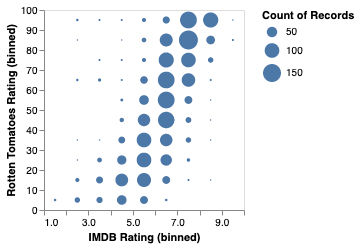

In [11]:
# Source: https://vega.github.io/vega-lite/examples/circle_binned.html

Vl.new()
|> Vl.data_from_url("https://vega.github.io/editor/data/movies.json")
|> Vl.mark(:circle)
|> Vl.encode_field(:x, "IMDB Rating", bin: [maxbins: 10])
|> Vl.encode_field(:y, "Rotten Tomatoes Rating", bin: [maxbins: 10])
|> Vl.encode(:size, aggregate: :count)

### 2D Histogram heatmap

Another version of 2D histogram, with color scale representing value frequency.

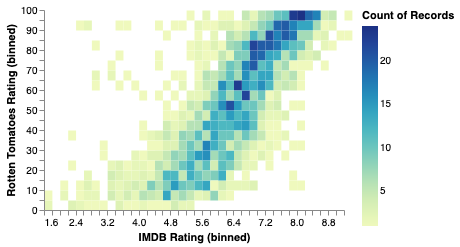

In [12]:
# Source: https://vega.github.io/vega-lite/examples/rect_binned_heatmap.html

Vl.new(width: 300, height: 200)
|> Vl.data_from_url("https://vega.github.io/editor/data/movies.json")
|> Vl.transform(
  filter: [
    and: [
      [field: "IMDB Rating", valid: true],
      [field: "Rotten Tomatoes Rating", valid: true]
    ]
  ]
)
|> Vl.mark(:rect)
|> Vl.encode_field(:x, "IMDB Rating", bin: [maxbins: 60])
|> Vl.encode_field(:y, "Rotten Tomatoes Rating", bin: [maxbins: 40])
|> Vl.encode(:color, aggregate: :count)
|> Vl.config(view: [stroke: nil])

### 2D Ordinal heatmap

A heatmap similar to the above, but with already discrete categories.

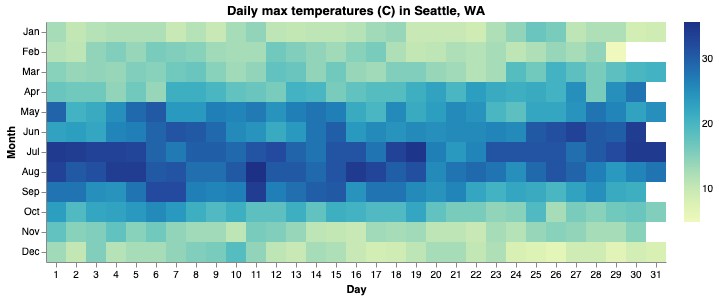

In [13]:
# Source: https://vega.github.io/vega-lite/examples/rect_heatmap_weather.html

Vl.new(title: "Daily max temperatures (C) in Seattle, WA")
|> Vl.data_from_url("https://vega.github.io/editor/data/seattle-weather.csv")
|> Vl.mark(:rect)
|> Vl.encode_field(:x, "date",
  time_unit: :date,
  type: :ordinal,
  title: "Day",
  axis: [label_angle: 0, format: "%e"]
)
|> Vl.encode_field(:y, "date",
  time_unit: :month,
  type: :ordinal,
  title: "Month"
)
|> Vl.encode_field(:color, "temp_max",
  aggregate: :max,
  type: :quantitative,
  legend: [title: nil]
)
|> Vl.config(view: [stroke: nil])

## Scatter and strip plots - TBD

### Scatterplot

A scatterplot represents 2D data directly as geometric points.

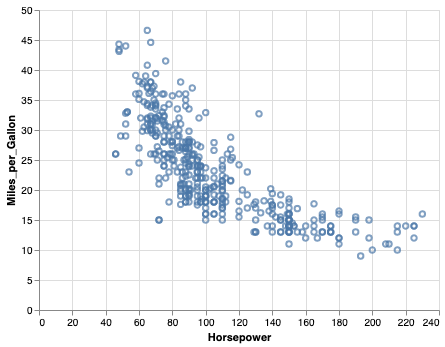

In [14]:
# Source: https://vega.github.io/vega-lite/examples/point_2d.html

Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/cars.json")
|> Vl.mark(:point)
|> Vl.encode_field(:x, "Horsepower", type: :quantitative)
|> Vl.encode_field(:y, "Miles_per_Gallon", type: :quantitative)

### Strip plot

Shows the relationship between two values using tick marks.

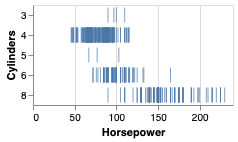

In [15]:
# Source: https://vega.github.io/vega-lite/examples/tick_strip.html

Vl.new()
|> Vl.data_from_url("https://vega.github.io/editor/data/cars.json")
|> Vl.mark(:tick)
|> Vl.encode_field(:x, "Horsepower", type: :quantitative)
|> Vl.encode_field(:y, "Cylinders", type: :ordinal)

### Colored scatterplot

Scatterplot with clear point groups.

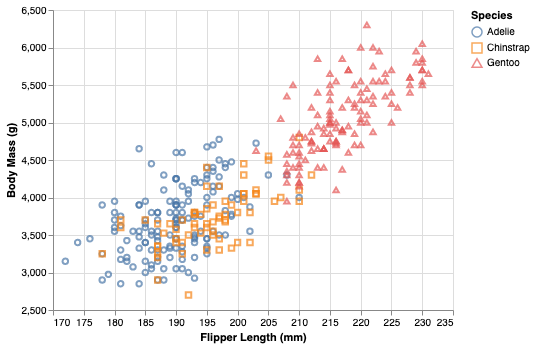

In [16]:
# Source: https://vega.github.io/vega-lite/examples/point_color_with_shape.html

Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/penguins.json")
|> Vl.mark(:point)
|> Vl.encode_field(:x, "Flipper Length (mm)", type: :quantitative, scale: [zero: false])
|> Vl.encode_field(:y, "Body Mass (g)", type: :quantitative, scale: [zero: false])
|> Vl.encode_field(:color, "Species", type: :nominal)
|> Vl.encode_field(:shape, "Species", type: :nominal)

## Line charts

### Line chart

A simple chart resulting from linking individual points.

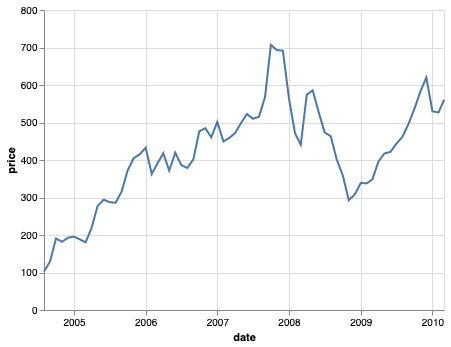

In [17]:
# Source: https://vega.github.io/vega-lite/examples/line.html

Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/stocks.csv")
|> Vl.transform(filter: "datum.symbol == 'GOOG'")
|> Vl.mark(:line)
|> Vl.encode_field(:x, "date", type: :temporal)
|> Vl.encode_field(:y, "price", type: :quantitative)

### Multi series line chart

Multiple line charts combined together.

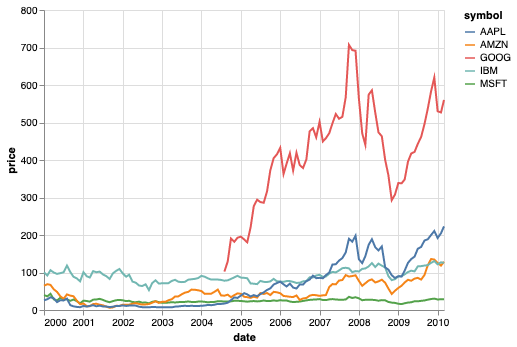

In [18]:
# Source: https://vega.github.io/vega-lite/examples/line_color.html

Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/stocks.csv")
|> Vl.mark(:line)
|> Vl.encode_field(:x, "date", type: :temporal)
|> Vl.encode_field(:y, "price", type: :quantitative)
|> Vl.encode_field(:color, "symbol", type: :nominal)

### Line chart with point markers

Marking individual points on top of the line.

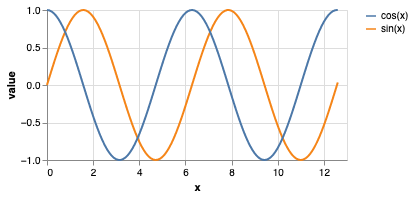

In [19]:
# Source: https://vega.github.io/vega-lite/examples/sequence_line_fold.html

Vl.new(width: 300, height: 150)
|> Vl.data(sequence: [start: 0, stop: 12.7, step: 0.1, as: "x"])
|> Vl.transform(calculate: "sin(datum.x)", as: "sin(x)")
|> Vl.transform(calculate: "cos(datum.x)", as: "cos(x)")
|> Vl.transform(fold: ["sin(x)", "cos(x)"])
|> Vl.mark(:line)
|> Vl.encode_field(:x, "x", type: :quantitative)
|> Vl.encode_field(:y, "value", type: :quantitative)
|> Vl.encode_field(:color, "key", type: :nominal, title: nil)

## Area charts and streamgraphs

### Area chart

An area chart represents quantitative data and is based on line chart.

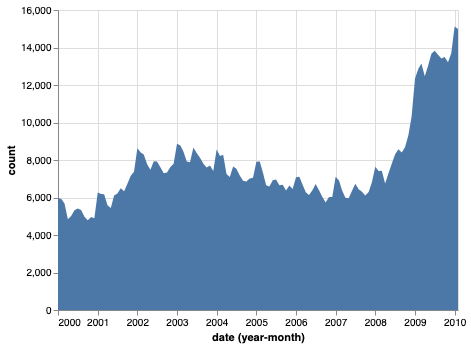

In [20]:
# Source: https://vega.github.io/vega-lite/examples/area.html

Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/unemployment-across-industries.json")
|> Vl.mark(:area)
|> Vl.encode_field(:x, "date", time_unit: :yearmonth, axis: [format: "%Y"])
|> Vl.encode_field(:y, "count", aggregate: :sum, title: "count")

### Stacked area chart

A combination of multiple area charts allowing for easy visual comparison.

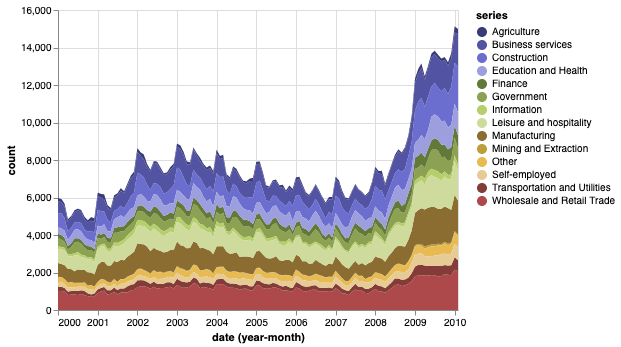

In [21]:
# Source: https://vega.github.io/vega-lite/examples/stacked_area.html

Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/unemployment-across-industries.json")
|> Vl.mark(:area)
|> Vl.encode_field(:x, "date", time_unit: :yearmonth, axis: [format: "%Y"])
|> Vl.encode_field(:y, "count", aggregate: :sum, title: "count")
|> Vl.encode_field(:color, "series", scale: [scheme: "category20b"])

### Streamgraph

A streamgraph is a type of area chart which is displaced around a centerl axis.

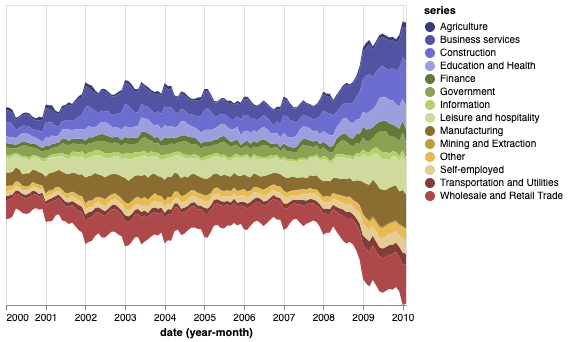

In [22]:
Vl.new(width: 400, height: 300)
|> Vl.data_from_url("https://vega.github.io/editor/data/unemployment-across-industries.json")
|> Vl.mark(:area)
|> Vl.encode_field(:x, "date", time_unit: :yearmonth, axis: [format: "%Y"])
|> Vl.encode_field(:y, "count", aggregate: :sum, axis: nil, stack: :center)
|> Vl.encode_field(:color, "series", scale: [scheme: "category20b"])

## Circular plots

### Pie chart

A pie chart encodes proportional differences among a set of numeric values
as the angular extent and area of a circular slice.

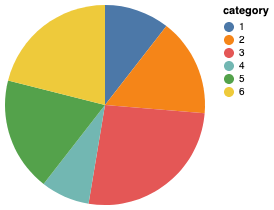

In [23]:
data = [
  %{"category" => 1, "value" => 4},
  %{"category" => 2, "value" => 6},
  %{"category" => 3, "value" => 10},
  %{"category" => 4, "value" => 3},
  %{"category" => 5, "value" => 7},
  %{"category" => 6, "value" => 8}
]

Vl.new()
|> Vl.data_from_values(data)
|> Vl.mark(:arc)
|> Vl.encode_field(:theta, "value", type: :quantitative)
|> Vl.encode_field(:color, "category", type: :nominal)
|> Vl.config(view: [stroke: nil])

### Radial plot

This radial plot uses both angular and radial extent to convey
multiple dimensions of data. However, this approach is not perceptually
effective, as viewers will most likely be drawn to the total area of
the shape, conflating the two dimensions.

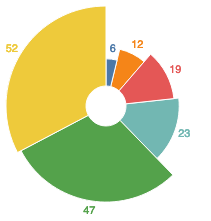

In [24]:
# Source: https://vega.github.io/vega-lite/examples/arc_radial.html

Vl.new()
|> Vl.data_from_series(data: [12, 23, 47, 6, 52, 19])
|> Vl.encode_field(:theta, "data", type: :quantitative, stack: true)
|> Vl.encode_field(:radius, "data", scale: [type: :sqrt, zero: true, range_min: 20])
|> Vl.encode_field(:color, "data", type: :nominal, legend: nil)
|> Vl.layers([
  Vl.new()
  |> Vl.mark(:arc, inner_radius: 20, stroke: "#fff"),
  Vl.new()
  |> Vl.mark(:text, radius_offset: 10)
  |> Vl.encode_field(:text, "data", type: :quantitative)
])
|> Vl.config(view: [stroke: nil])